In [55]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

In [56]:
problem_class = "CarSequencing"
problem_title = ''
if problem_class == 'CarSequencing':
    problem_title = 'Car sequencing'
elif problem_class == 'CoveringArray':
    problem_title = 'Covering array'
elif problem_class == 'SocialGolfers':
    problem_title = 'Social golfers'
f = open(f"data/datasets/{problem_class}.json")
dataset = json.load(f)
f.close()

In [57]:
def load_folder(folder):
    files = os.listdir(folder)
    res = {}
    for file in files:
        path = os.path.join(folder, file)
        if os.path.isdir(path):
            res[file] = load_folder(path)
        else:
            f = open(path)
            res[file] = json.load(f)
            f.close()
    return res

In [58]:
predictions = load_folder(f"data/predictions/{problem_class}")

In [59]:
predictions.keys()

dict_keys(['small_k_5', 'c-nn_k_5'])

In [60]:
instance_dataset = {}
for datapoint in dataset:
    inst = datapoint["instance_name"]
    times = {t["combination"]: t["time"] for t in datapoint["all_times"]}
    instance_dataset[inst] = times
combinations = [t["combination"] for t in dataset[0]["all_times"]]

def is_competitive(vb, option):
    return (option < 10 or vb * 2 >= option) and option < 3600
if problem_class == "CarSequencing":
    combinations = [c for c in combinations if not "06_chPrunedLevels.eprime" in c]
combinations = sorted(combinations)
SAMPLE_KEY = list(predictions.keys())[1]
seed_instances = {"train": {}, "validation": {}, "test": {}} #fold: instances of the fold
for key in predictions[SAMPLE_KEY]:
    strip = key.replace("_predictions", "")
    strip = strip.split("_")
    # print(key)
    set_type, seed = strip[0], int(strip[1])
    for pred in predictions[SAMPLE_KEY][key]: 
        instance = pred["inst"]
        if not seed in seed_instances[set_type]:
            seed_instances[set_type][seed] = []    
        seed_instances[set_type][seed].append(instance)
if problem_class == "CarSequencing":
    f = open("data/features/CarSequencing/car_sequencing_fzn2feat.json")
    _fzn2feat_times = json.load(f)
    f.close()
    fzn2feat_times = {instance["inst"]: instance["time"] for instance in _fzn2feat_times}
else:
    df = pd.read_csv(f"data/features/{problem_class}/fzn2feat_{problem_class}.csv")
    fzn2feat_times = {df.iloc[i]["inst"]: df.iloc[i]["time"] for i in range(len(df))}
f = open(f"data/features/{problem_class}/dnn_times.json")
_dnn_times = json.load(f)
f.close()
dnn_times = {instance["inst"]: instance["time"] for instance in _dnn_times}
preditions_dataset = {}
for selection_algorithm in predictions.keys():
    if selection_algorithm == "par10scores.json":
        continue
    if not selection_algorithm in preditions_dataset:
        preditions_dataset[selection_algorithm] = {}
    for set_type_prediction_fold in predictions[selection_algorithm]:
        strip = set_type_prediction_fold.replace("_predictions", "")
        strip = strip.split("_")
        set_type, seed = strip[0], int(strip[1])
        if not set_type in preditions_dataset[selection_algorithm]:
            preditions_dataset[selection_algorithm][set_type] = {}
        if not seed in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][seed] = []
        for pred in predictions[selection_algorithm][set_type_prediction_fold]:
            inst = pred["inst"]
            choosen_option = pred["chosen_option"]
            if problem_class == "CarSequencing":
                choosen_option = choosen_option.replace("06_chPrunedLevels", "01_compact")
            pred_time = pred["time"] if "time" in pred else 0
            if "fzn2feat" in selection_algorithm:
                pred_time += fzn2feat_times[inst]
            elif "c-nn" in selection_algorithm or \
                "fully_neural" in selection_algorithm or \
                'only' in selection_algorithm or \
                "regression" in selection_algorithm or \
                "small" in selection_algorithm:
                pred_time += dnn_times[inst]
            elif selection_algorithm.split("_")[-1] in ["cf", "bf", "rf"]:
                pred_time += dnn_times[inst] + fzn2feat_times[inst]
            else:
                raise Exception(f"wut {selection_algorithm}?")
            if inst in seed_instances[set_type][seed]:
                preditions_dataset[selection_algorithm][set_type][seed].append(
                    instance_dataset[inst][choosen_option] + pred_time
                )
for selection_algorithm in preditions_dataset:
    for set_type in preditions_dataset[selection_algorithm]:
        for seed in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][seed] = sum(preditions_dataset[selection_algorithm][set_type][seed])

In [61]:
for combination in combinations:
    preditions_dataset[combination] = {}
    for set_type in seed_instances.keys():
        preditions_dataset[combination][set_type] = {}
        for seed in seed_instances[set_type].keys():
            preditions_dataset[combination][set_type][seed] = []
            for inst in seed_instances[set_type][seed]:
                preditions_dataset[combination][set_type][seed] += [instance_dataset[inst][combination]]
            preditions_dataset[combination][set_type][seed] = sum(preditions_dataset[combination][set_type][seed])
     
preditions_dataset["virtual best"] = {}       
for set_type in seed_instances.keys():
    preditions_dataset["virtual best"][set_type] = {}
    for seed in seed_instances[set_type].keys():
        preditions_dataset["virtual best"][set_type][seed] = []
        for inst in seed_instances[set_type][seed]:
            preditions_dataset["virtual best"][set_type][seed] += [min(instance_dataset[inst].values())]
        preditions_dataset["virtual best"][set_type][seed] = sum(preditions_dataset["virtual best"][set_type][seed])

In [62]:
opt_times = {comb["combination"]:0 for comb in dataset[0]["all_times"]}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        opt_times[t["combination"]] += t["time"]
sb_key = min(opt_times.items(), key = lambda x: x[1])[0]
print(sb_key)

chuffed_02_compact.eprime


In [65]:
min(preditions_dataset['small_k_5']['test'].items(), key= lambda x: x[1])

(2, 199906.23918942423)

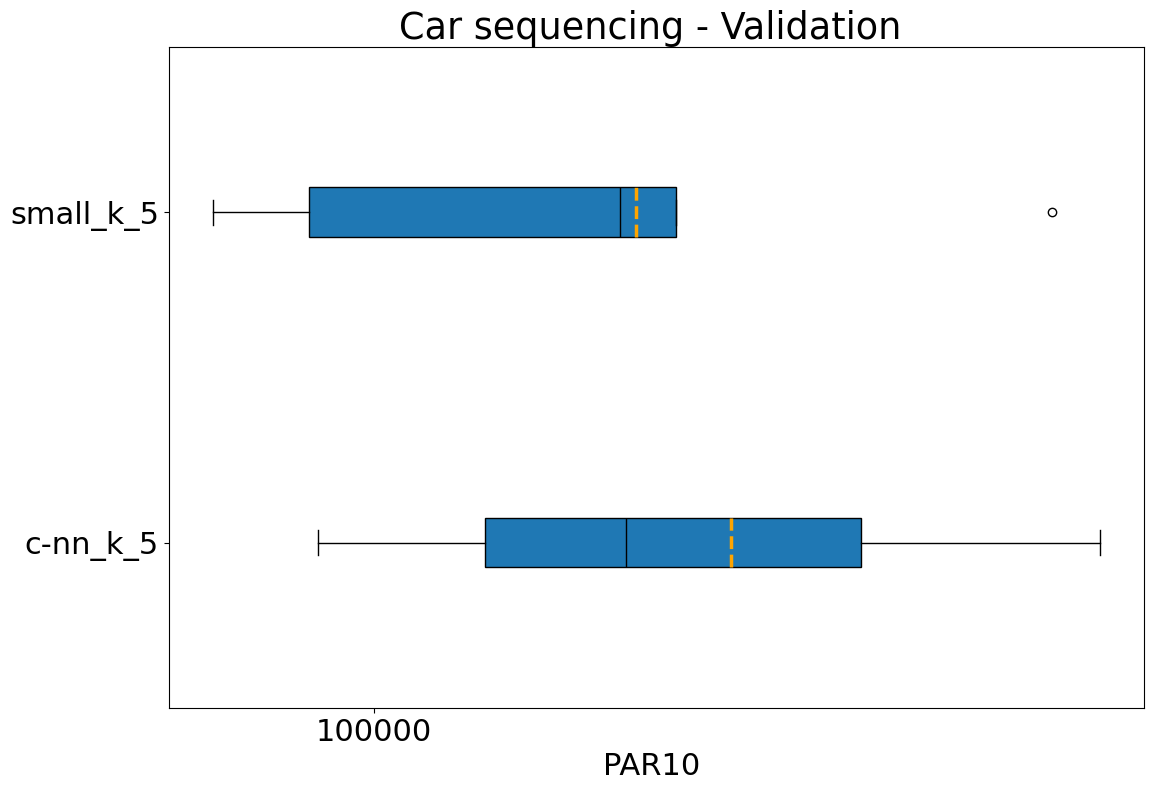

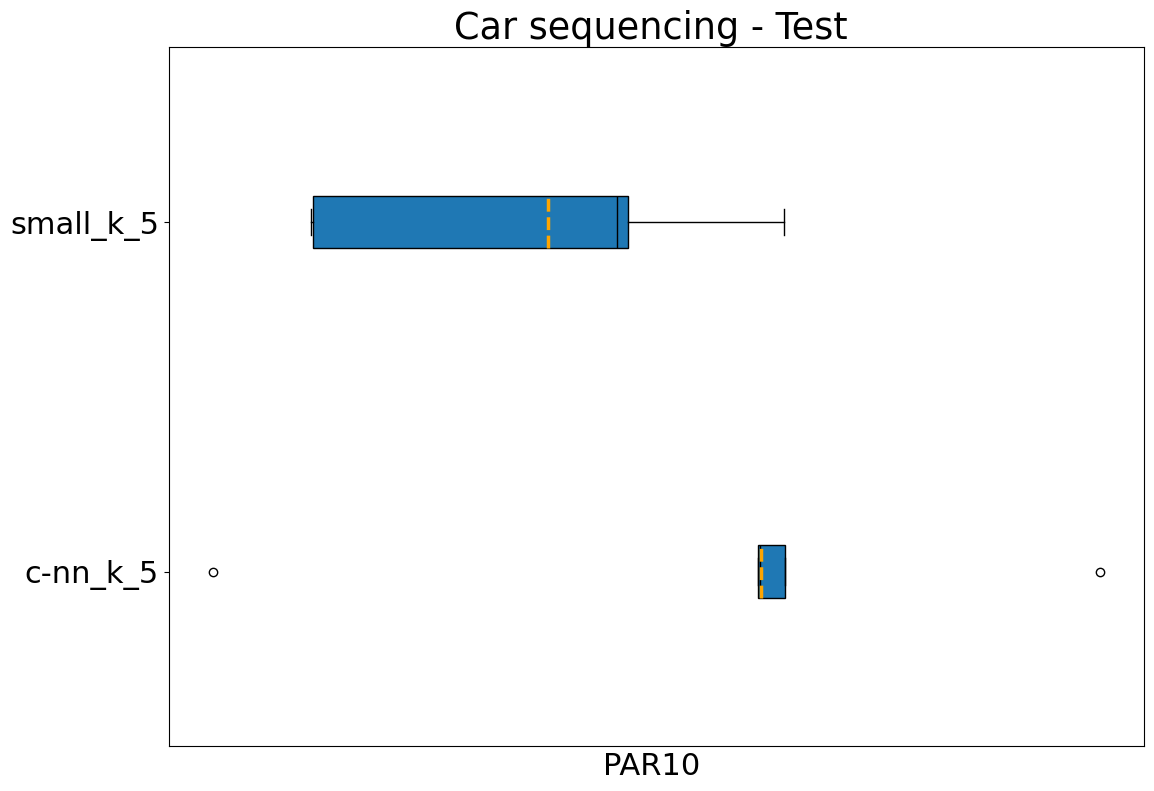

In [67]:
size = 12, 8
import matplotlib
y_label = True
normalised = False
rc('font', size=22)

for set_to_use in ["validation", "test"]: #["train", "validation", 'test']:
    plot_predictions = {}
    for key in preditions_dataset.keys():
        # try:
            # if ("NN" in transform(key) and not "untuned" in key):
            if key != "virtual best":
                if key != sb_key and "eprime" in key:
                    continue
                if key != sb_key:
                    if normalised:
                        plot_predictions[key] = list(
                        (v - preditions_dataset['virtual best'][set_to_use][k])/(preditions_dataset[sb_key][set_to_use][k] - preditions_dataset['virtual best'][set_to_use][k]) 
                        for k,v in preditions_dataset[key][set_to_use].items())
                    else:
                        plot_predictions[key] = list(
                        v 
                        for v in preditions_dataset[key][set_to_use].values())
        # except Exception as e:
        #     print(key, e)

    plot = []

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: item[0]))
    plt.figure(figsize=size)
    plt.boxplot(list(sorted_data.values()),
                vert=False,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
                boxprops=dict(facecolor="#1F78B4"),
                meanline=True,
                medianprops=dict(color='black'))
    if y_label:
        plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))
    else:
        plt.yticks([])

    plt.xscale("log")
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().minorticks_off()
    # plt.axvline(v_line, color="red")
    if normalised:
        plt.axvline(1, color="red")
    plt.xlabel(f'PAR10 {"(normalised)" if normalised else ""}')
    plt.ylabel('')
    plt.tight_layout()
    plt.title(f"{problem_title} - {set_to_use.capitalize()} {'(normalised)' if normalised else ''}")
    plt.savefig(f"results_{set_to_use}_{problem_class}{'(normalised)' if normalised else ''}.pdf", format="pdf", bbox_inches='tight')
    plt.show()

dict_keys(['100', '50', '75', '62', '68'])


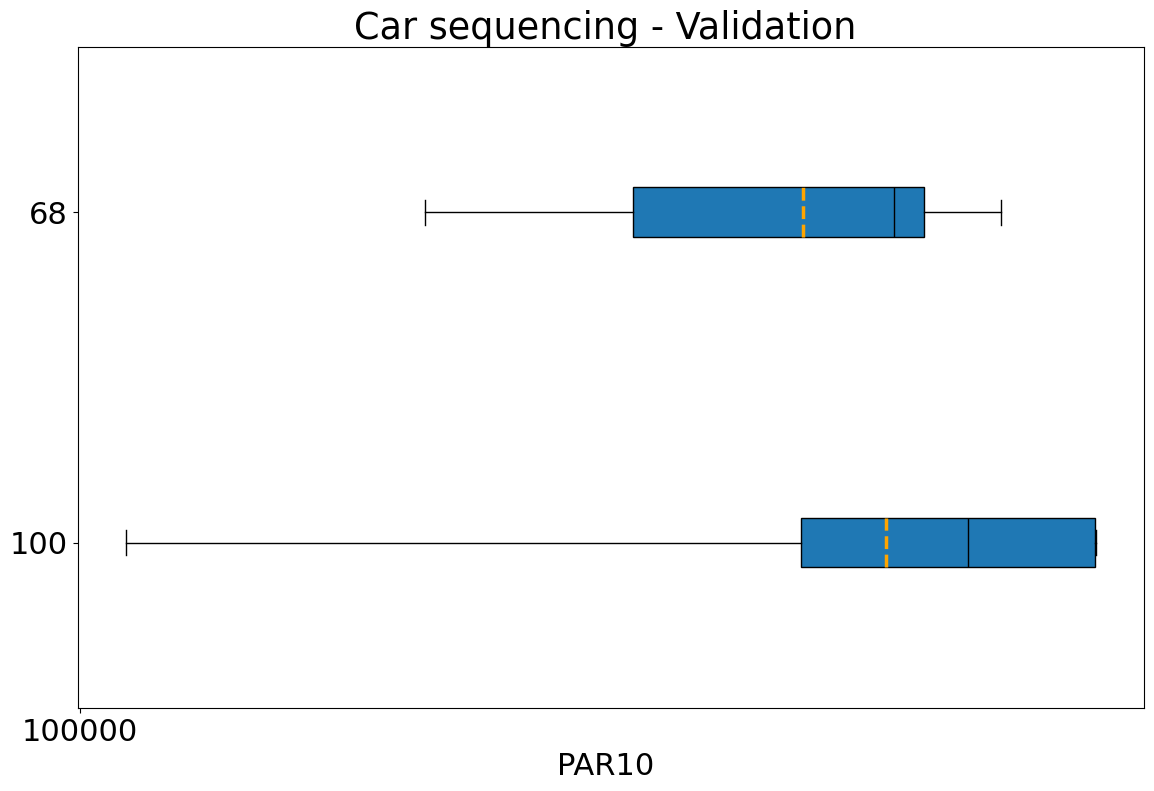

In [82]:
size = 12, 8
import matplotlib
y_label = True
normalised = False
rc('font', size=22)
problem_class = "CarSequencing"
if problem_class == 'CarSequencing':
    problem_title = 'Car sequencing'
elif problem_class == 'CoveringArray':
    problem_title = 'Covering array'
elif problem_class == 'SocialGolfers':
    problem_title = 'Social golfers'

with open(f'data/history/CarSequencing/small_5/historyTrainingCarSequencing.json') as f:
    history = json.load(f)
print(history.keys())
scores_comp = history['100']
best = history['68']
for set_to_use in ["validation"]: #["train", "validation", 'test']:
    plot_predictions = {
        '100': [comp['score'] for comp in scores_comp],
        '68': [b['score'] for b in best]
    }
        # except Exception as e:
        #     print(key, e)

    plot = []

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: item[0]))
    plt.figure(figsize=size)
    plt.boxplot(list(sorted_data.values()),
                vert=False,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
                boxprops=dict(facecolor="#1F78B4"),
                meanline=True,
                medianprops=dict(color='black'))
    if y_label:
        plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))
    else:
        plt.yticks([])

    plt.xscale("log")
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().minorticks_off()
    # plt.axvline(v_line, color="red")
    if normalised:
        plt.axvline(1, color="red")
    plt.xlabel(f'PAR10 {"(normalised)" if normalised else ""}')
    plt.ylabel('')
    plt.tight_layout()
    plt.title(f"{problem_title} - {set_to_use.capitalize()} {'(normalised)' if normalised else ''}")
    plt.savefig(f"results_{set_to_use}_{problem_class}_.pdf", format="pdf", bbox_inches='tight')
    plt.show()